# Introduction

Understanding chemical reaction rates is a fundamental aspect of physical chemistry, catalysis, and chemical engineering. Reaction kinetics governs the temporal behavior of chemical systems, influencing yields, safety, and operational efficiency across both academic and industrial applications. The ability to simulate these dynamics is essential for designing chemical processes, interpreting reaction mechanisms, and predicting system behavior under varying conditions.

This project presents `rxnrate2`, a Python-based modeling tool developed to simulate the time evolution of chemical species in both linear and nonlinear reaction systems. The package numerically integrates systems of ordinary differential equations (ODEs) derived from user-defined reactions and initial conditions. It supports arbitrary reaction topologies, including irreversible and reversible reactions, and provides a visual, interactive interface using Streamlit for real-time exploration of kinetic parameters.

## 1. Character: Modeling Reaction Dynamics with ODEs

The focus of this project is on modeling chemical reaction networks using ODEs, which describe how concentrations of chemical species evolve over time. In simple systems, such as unimolecular decays or linear reaction sequences, the rate of change of concentrations can be expressed as a matrix differential equation:


$$
\frac{d}{dt}
\begin{bmatrix}
[A] \\
[B] \\
[C]
\end{bmatrix}
=
\mathbf{M}
\begin{bmatrix}
[A] \\
[B] \\
[C]
\end{bmatrix}
$$

where **${M}$** is a matrix constructed from the forward and reverse rate constants. These linear systems allow numerical solutions, and are particularly useful when modeling unimolecular processes or linear networks.
where the matrix **M** contains the rate constants corresponding to each reaction step. Such linear models are analytically tractable and serve as useful approximations for various physical and biochemical processes.

However, many reactions in real-world systems exhibit nonlinear behavior. This nonlinearity arises when reaction rates depend on the product of concentrations of two or more species, as in the classic bimolecular reaction:

$$
A + B \rightarrow C
$$

with a rate law:

$$
\frac{d[C]}{dt} = k[A][B]
$$

This is nonlinear because the rate depends on the product $[A][B]$. In reversible reactions, both forward and reverse processes must be considered:

$$
A + B \rightleftharpoons C \quad \Rightarrow \quad \frac{d[C]}{dt} = k_f[A][B] - k_r[C]
$$
 

These equations reflect mass-action kinetics and typically require numerical methods for solution due to their nonlinear nature. The `rxnrate2` package uses `solve_ivp` from SciPy with the Runge-Kutta method `RK45` to integrate such systems over time.

## 2. Setting: A General Python Framework for Reaction Kinetics

The tool is implemented as a modular and extensible Python package. It allows users to define arbitrary chemical reactions, specify whether each is reversible, and assign forward and reverse rate constants. Initial concentrations can be set for each species, and the resulting system of ODEs is automatically constructed and solved numerically.

Both simple and complex reaction networks can be modeled without requiring the user to manually derive differential equations. The framework handles the mathematical formulation internally, making it suitable for chemical education, early-stage research, and prototyping.

The front-end interface is built using Streamlit, enabling interactive simulations with sliders for rate constants and concentrations, along with dynamic plots of concentration versus time. This visual component supports intuitive understanding of reaction dynamics, equilibrium behavior, and sensitivity to kinetic parameters.

## 3. Problem: Lack of Generalized Tools for Arbitrary Reactions

Traditional approaches to reaction modeling often rely on analytical solutions, which are limited to linear or simplified cases. In more complex systems—such as those involving feedback loops, reversible bimolecular steps, or multiple coupled reactions—closed-form solutions are not generally available. Existing software may be either overly specialized or require deeper learning curves.

There is therefore a need for a flexible, accessible simulation tool that can accommodate both standard and customized kinetic models, particularly for nonlinear systems. This project addresses that need by providing a numerical and visual environment to explore chemical kinetics systematically.

## 4. Solution: Numerical Integration and Visualization of Reaction Networks

The `rxnrate2` package offers a computational approach to simulate the progression of chemical reactions over time. By supporting a wide range of kinetic models—including linear sequences, branched pathways, and nonlinear interactions, the package unites theoretical kinetics and practical analysis.

Users input species, reactions, rate constants, and initial conditions; the package then constructs the corresponding system of ODEs and solves them over a specified time domain. Concentration profiles are plotted dynamically, allowing the study of equilibrium positions, rate-limiting steps, and the effects of perturbations in the system.

This tool could be particularly relevant for investigating biochemical networks, catalytic cycles, and reaction mechanisms with complex stoichiometry. It provides a platform for conceptual understanding, hypothesis testing, and rapid iteration in kinetic studies.


# Materials & Methods

The core of this package is the usage of ODEs that describe the time evolution of concentrations for each species in a reaction network (be it a linear or non-linear ODE). 

There are two main modeling approaches implemented:

## 1. Matrix-Based Linear Systems
This method is for first-order reactions as it assumes linear rate laws. That means that the reactions are of the form A → B → C, as mentioned and explained more in detail in the chemical background section, with the possibility of it being a reversible reaction. A matrix $M$ is constructed with the rate constant values given by the user with the function `build_M_matrix`.It can have only numerical values, as using symbolic values (such as $k_1$ or $k_2$) wouldn't work when trying to solve it. The $\vec{y}$ vector is a vector of the species' concentrations. Using the function `ode_system`, the system is defined as:

$$ \frac{d\vec{y}}{dt} = M \vec{y} $$

For the solving, the system uses `scipy.integrate.solve_ivp` inside the function `solve_reaction` to solve the equations numerically over a given time interval using the technique RK45. In the end, the concentration are plotted with the function `plot_solution`. 

 

**Other tools used**:
- `NumPy`: matrix and array operations
- `SciPy`: solving ODEs, specifically with the method RK45
- `Matplotlib`: plotting the concentration over time

As an example, for the reaction 
$$ A → B ⇌ C $$
with $k_{f,AB} = 1.0, k_{f,BC} = 0.5, k_{r,BC}= 0.2$, the system would look like: 

$$
\frac{d}{dt}
\begin{bmatrix}
[A] \\
[B] \\
[C]
\end{bmatrix}
=
\begin{bmatrix}
-1.0 & 0.0 & 0.0 \\
1.0 & -0.5 & 0.2 \\
0.0 & 0.5 & -0.2
\end{bmatrix}
\begin{bmatrix}
[A] \\
[B] \\
[C]
\end{bmatrix}
$$

The initial concentrations are, in alphabetical order $0.5, 0.0, 0.0$.
The following code section is the final output, which the user will get.



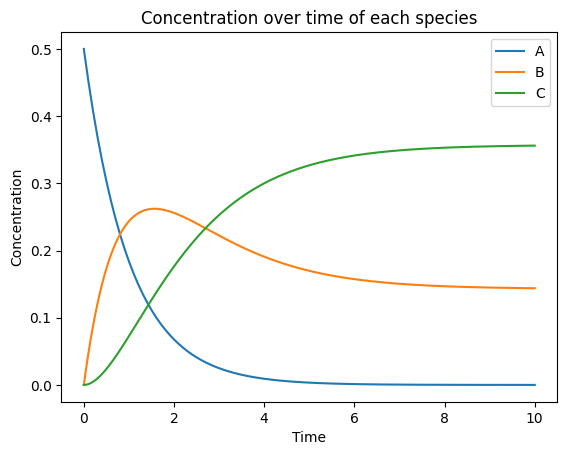

In [6]:
from rxnrate2.ODE_linearrxn import solve_reaction, plot_solution

species_test = ['A', 'B', 'C']
reactions_test = [
    ('A', 'B', 1.0, None),
    ('B', 'C', 0.5, 0.2)
]
y0_vals = [0.5, 0.0, 0.0]  

sol, M = solve_reaction(species_test, reactions_test, y0_vals)
plot_solution(sol, species_test)

## 2. Function-Based Nonlinear Systems

The general way of solving the non-linear ODEs, constructed from the mass-action kinetics, as described in the introduction, is based on constructing a system consisting of a concentration vector, as previously and a matrix construction that will work as a function of the concentrations:
$$ \frac{d\vec{y}}{dt} = f(\vec{y})$$
The function of the concentration vector, $f(\vec{y})$ and the concentration vector itself $\vec{y}$ looks like, in general:
$$
\frac{d}{dt}
\begin{bmatrix}
[X] \\
[Y] \\
[Z] \\
[...]
\end{bmatrix}
=
\begin{bmatrix}
(-1)^nk_{[XY...]}[X][Y][...] + (-1)^nk_{[XY...]}[X][Y][...] + ...\\
(-1)^nk_{[XY...]}[X][Y][...] + (-1)^nk_{[XY...]}[X][Y][...] + ...\\
(-1)^nk_{[XY...]}[X][Y][...] + (-1)^nk_{[XY...]}[X][Y][...] + ... \\
...
\end{bmatrix} \quad \Rightarrow \quad \frac{d\vec{y}}{dt} = f(\vec{y})
$$
In the matrix, $n\,=\,-1$ if it is the rate involves the consumption of a species and $n\,=\,1$ if it involves the formation of the species. $[...]$ represents the concentration of a certain species and $k_{[XY...]}$ represents the rate constant for a specific reaction.
The right-hand side (RHS) of this ODE has to be built by interpreting the reaction terms directly. Hence, the function `build_RHS` was built to do that. Once the RHS is created, the system can proceed to solving the system with `scipy.integrate.solve_ivp` (inside the function `solve_reactions`) over a given time interval, and it is also where the initial concentrations of each species is taken into account.
After solving the ODE, the concentration of each species is plotted over time using the function `plot_solution`, which is the final output of the code.

**Tools used**:
- `NumPy`: matrix and array operations
- `SciPy`: solving ODEs
- `Matplotlib`: plotting

An explicitly written out example would be a second order reaction like A + B → C (irreversible). Hence the system would look like, for this example:
$$
\frac{d[A]}{dt} = -k_f [A][B]
$$

$$
\frac{d[B]}{dt} = -k_f [A][B]
$$

$$
\frac{d[C]}{dt} = +k_f [A][B]
$$

with $k_f$ being the forward reaction rate and $k_r$ being the backwards (or return) reaction rate.
Or, if the reaction was reversible:
$$
\frac{d[A]}{dt} = -k_f [A][B] + k_r [C]
$$

$$
\frac{d[B]}{dt} = -k_f [A][B] + k_r [C]
$$

$$
\frac{d[C]}{dt} = +k_f [A][B] - k_r [C]
$$


The following code section is a run simulation of the code for the following multiple reactions:
$$ A + B ⇌ C $$   
$$k_f = 1.0\, ; k_r = 0.5 $$
$$ C → A $$                  
$$ k_f = 0.2 $$
$$ A + C + B ⇌ D + E $$ 
$$ k_f = 0.5\, ; k_r = 0.5 $$

The initial concentration are, in alphabetical order: $ 1.0\;, 1.0\;, 0.0\;, 0.0\;, 0.2\;.$

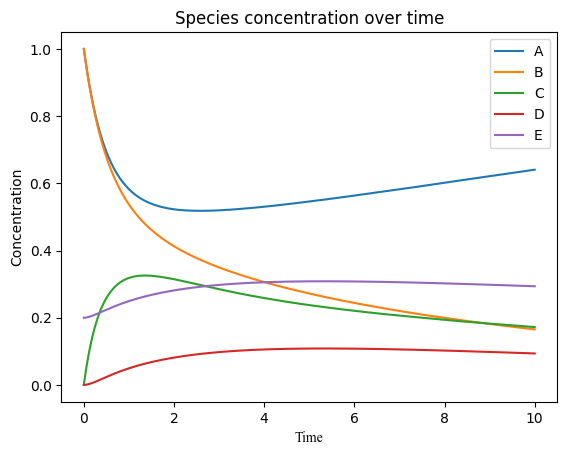

In [7]:
from rxnrate2.ODE_nonlinear import solve_reactions, plot_solution

species_test = ['A', 'B', 'C', 'D', 'E']
reactions_test = [
    (['A', 'B'], ['C'], 1.0, 0.5),
    (['C'], ['A'], 0.2, None),
    (['A', 'C', 'B'], ['D', 'E'], 0.5, 0.5)
]
y0_vals = [1.0, 1.0, 0.0, 0.0, 0.2]

sol = solve_reactions(species_test, reactions_test, y0_vals)
plot_solution(sol, species_test)


## 3. Interface Design
In addition to the core Python-based modeling, an interactive web application using **Streamlit** was developed, an open-source framework designed for creating data apps. Streamlit allows Python scripts to be instantly converted into shareable web interfaces, making our chemical kinetics model accessible to users without coding experience.

To build the web interface, several core Streamlit functions were used, among the most notable:

- `st.title()` and `st.header()` to define page sections and structure the layout.
- `st.text_input()` and `st.number_input()` to collect user-defined parameters, such as concentrations and rate constants.
- `st.button()` to trigger calculations and update model outputs when clicked.
- `st.write()` to display outputs and formatted text dynamically.
- `st.pyplot()` and `st.line_chart()` to visualize time-course data and other results graphically.

We also used `@st.cache_data` to cache expensive function calls and prevent redundant recalculations, improving performance.

The app reads user input in real-time, runs the reaction model, and returns predictions and plots instantly. This interactivity enables exploration of reaction behavior under different parameter settings.

For deployment, we used *Streamlit Community Cloud*, which connects to our GitHub repository and automatically updates the live version of the app whenever changes are pushed.



# Results

The objective of this project was to create a versatile and interactive simulation tool capable of modeling both linear and nonlinear chemical reaction networks. Based on the implementation described in the Materials & Methods section, this goal was successfully achieved.

The `rxnrate2` package accurately computes the time evolution of chemical species using systems of ordinary differential equations (ODEs) derived from user-defined reaction schemes. Two primary modeling strategies were implemented and validated:

- **Matrix-based models** for linear, first-order reaction systems, where the time derivative of the concentration vector is obtained via multiplication by a rate constant matrix.
- **Function-based models** for nonlinear systems, such as bimolecular and termolecular reactions, where the rate of change is determined by mass-action kinetics and requires dynamic construction of the right-hand side of the ODE system.

In both approaches, the use of `solve_ivp` from SciPy with the Runge-Kutta `RK45` method enabled stable and accurate integration of the systems over a user-defined time interval. Resulting concentration profiles matched theoretical expectations for standard test cases, including irreversible and reversible reactions.

For instance, in the linear case of: $ A → B ⇌ C $ with defined rate constants and initial conditions, the system matrix correctly produced exponential decay and interconversion behavior among species. Similarly, nonlinear examples were also successfully simulated using arbitrary stoichiometries and mixed reaction orders. The concentration-time curves provided clear insight into the transient and equilibrium behavior of the system.

Additionally, the development of a Streamlit-based web interface proved effective for enabling user interaction. The app reads user-specified species, reactions, rate constants, and initial concentrations, then computes and displays the time evolution plots dynamically. Real-time parameter adjustments are reflected immediately in the visual outputs, facilitating intuitive understanding and rapid prototyping.

Key features of the interface include:
- Support for both linear and nonlinear kinetic models
- Interactive input of rate constants and initial concentrations
- On-demand computation and graph rendering
- Use of `@st.cache_data` to optimize performance by minimizing redundant calculations

The interface was successfully deployed using *Streamlit Community Cloud*, ensuring accessibility to users without Python programming experience.

In summary, the simulation tool meets its intended functionality: it allows users to define complex reaction networks, solve them numerically, and visualize the results through a clean and accessible interface. The tool is suitable for both instructional and exploratory purposes, and serves as a foundation for further development, such as support for temperature dependence, symbolic kinetics, or parameter fitting.





# Discussion

This project set out to build a general-purpose, interactive framework for simulating chemical reaction kinetics using numerical methods. The resulting package, `rxnrate2`, successfully provides a means to model both linear and nonlinear reaction systems by solving ODEs derived from user-defined reaction mechanisms. Beyond the core functionality, the inclusion of a user-friendly Streamlit interface makes the tool accessible for users without programming experience, increasing its utility in both pedagogical and research settings.

The project outcomes demonstrate how numerical integration methods can be used to simulate arbitrary reaction networks that go beyond the reach of analytical techniques. This enables exploration of complex reaction systems involving feedback, reversibility, and higher-order kinetics. However, several strengths and limitations must be considered in evaluating the tool’s effectiveness and scope.



## **Strengths**

### 1. Flexibility in Reaction Design
The package allows for full customization of reaction networks, including:
- Any number of reactants and products per reaction.
- Reversible or irreversible reactions.
- Arbitrary combinations of first-, second-, or higher-order terms (nonlinear mass-action kinetics).

This generality makes it adaptable to a wide range of chemical systems, from enzyme-catalyzed reactions to catalytic cycles and synthetic networks.

### 2. Dual Modeling Approaches
Two distinct ODE-solving approaches are implemented:
- A **matrix-based** formulation for linear systems, which is computationally efficient and mathematically transparent.
- A **function-based** formulation for nonlinear systems, supporting full generality and automated construction of complex rate equations.

Each approach is used appropriately depending on the system being modeled, offering both speed and generality where needed.

### 3. Real-Time Visualization
The integrated plotting capabilities provide immediate graphical feedback of concentration vs. time for each species, allowing users to:
- Visualize transient kinetics and steady-state behavior.
- Compare different kinetic regimes by adjusting input parameters interactively.
- Investigate effects of reversibility, reaction order, and initial conditions.

### 4. User Interface via Streamlit
The Streamlit web application:
- Lowers the barrier to entry for non-programmers.
- Allows real-time exploration and modification of kinetic models.
- Can be shared easily via the web (e.g., through Streamlit Cloud).
- Makes the tool suitable for use in educational demonstrations or early-stage modeling workflows.



## **Limitations**

### 1. Lack of Symbolic Expression Support
Currently, all rate constants and concentrations must be numerical. This means:
- No symbolic manipulation or algebraic simplification is possible.
- Analytical insights such as steady-state expressions or equilibrium conditions cannot be derived symbolically.
- This limits the use of the tool for theoretical derivations or exact analytical comparisons.

Future work could integrate packages like SymPy to allow for symbolic rate constant input and partial analytical treatment.

### 2. No Temperature or Pressure Dependence
All rate constants are treated as static values:
- There is no Arrhenius-type dependence on temperature.
- Pressure effects are not considered.
- Thus, the model assumes isothermal, constant-pressure systems.

Adding support for temperature-dependent rate constants and thermodynamic parameters would increase the applicability of the package to real-world systems and reactor modeling.

### 3. Limited Support for Advanced Kinetic Features
At present, the package does not support:
- Catalytic inhibition, Michaelis-Menten kinetics, or Hill kinetics.
- Parameter fitting or regression against experimental data.
- Event handling (e.g., pulse addition of a species at a given time).
- Stochastic modeling of low-concentration systems.

Such features are essential for modeling biochemical pathways, pharmacokinetics, or small-volume reactions and could be added in future iterations.

### 4. Scalability Constraints
Although the tool handles moderately sized systems well, very large or stiff systems may present performance issues:
- The RK45 solver may struggle with stiff differential equations.
- Long computation times may occur for large networks or finely sampled time intervals.
- The Streamlit UI, while convenient, is not optimized for high-performance computing scenarios.

In the future, adaptive solvers like `BDF`, or integration with parallel computing libraries, could improve performance on more complex networks.



In conclusion, the tool developed in this project provides a solid and flexible foundation for modeling reaction kinetics and visualizing their temporal evolution. Its strengths in usability and generality make it valuable for chemical education, prototyping, and mechanistic exploration. However, for advanced research applications, additional features, such as symbolic expressions or temperature effects would need to be integrated to enhance its scientific utility.

